# Notebook IC — v17

Gera Fig.1 (AWE/PEM e SOEC em subplots), Fig.2 (sobretensões), Fig.3 (dinâmica) e Tabela 2.

**Referências chave**:
- Zeng & Zhang (2010) *Progress in Energy and Combustion Science*. DOI: 10.1016/j.pecs.2009.11.002
- Carmo et al. (2013) *International Journal of Hydrogen Energy*. DOI: 10.1016/j.ijhydene.2013.01.151
- Laguna-Bercero (2012) *Renewable and Sustainable Energy Reviews*. DOI: 10.1016/j.rser.2011.07.083
- Azuan et al. (2019) *Science International (Lahore)*. PDF: https://www.sci-int.com/pdf/637054513794717651.pdf

In [1]:
# Reexecute todas as células para gerar as figuras/tabela.
import numpy as np, pandas as pd, matplotlib.pyplot as plt
R=8.314; F=96485
def Vrev_H2O(T): return 1.229 - 0.0009*(T-298.15)
def arrhenius_i0(i0_ref,Ea,T,Tref=298.15): return i0_ref*np.exp(-Ea/R*(1.0/T-1.0/Tref))
def tafel_eta(i,i0,alpha=0.5,T=298.15):
    i=max(i,1e-10); i0=max(i0,1e-12); return (R*T/(alpha*F))*np.log(i/i0)
def asr_vs_T(asr_ref,beta,T,Tref=298.15): return asr_ref*np.exp(-beta*(T-Tref))
def conc_eta(i,i_lim,m=2.0):
    x=min(i/i_lim,0.95); return 0.03*(x**m)/(1-x**m+1e-9)
def model_cell(TC,i,tech):
    T=TC+273.15
    if tech=='AWE': p=dict(etaF=0.98,i0_ref=2e-5,Ea=35000,asr_ref=0.40,beta=0.013,i_lim=2.8)
    elif tech=='PEM': p=dict(etaF=0.99,i0_ref=1e-6,Ea=42000,asr_ref=0.25,beta=0.018,i_lim=2.5)
    elif tech=='SOEC': p=dict(etaF=0.995,i0_ref=1e-3,Ea=25000,asr_ref=0.08,beta=0.005,i_lim=4.0)
    Vrev=Vrev_H2O(T); i0=arrhenius_i0(p['i0_ref'],p['Ea'],T)
    eta_act=tafel_eta(i,i0,T=T); asr=asr_vs_T(p['asr_ref'],p['beta'],T)
    eta_ohm=i*asr; eta_c=conc_eta(i,p['i_lim'])
    Vcell=Vrev+eta_act+eta_ohm+eta_c
    eta=(Vrev/Vcell)*p['etaF']
    if tech=='SOEC': eta=min(eta,0.95)
    return dict(Vrev=Vrev,Vcell=Vcell,eta=eta,eta_act=eta_act,eta_ohm=eta_ohm,eta_conc=eta_c)
def plot_style(): plt.rcParams.update({'figure.dpi':120,'font.size':11,'axes.grid':True})
plot_style()

### Figura 1 — Eficiência vs. temperatura (AWE/PEM e SOEC)

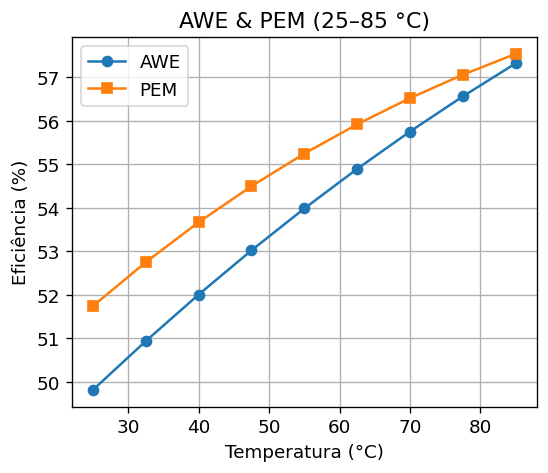

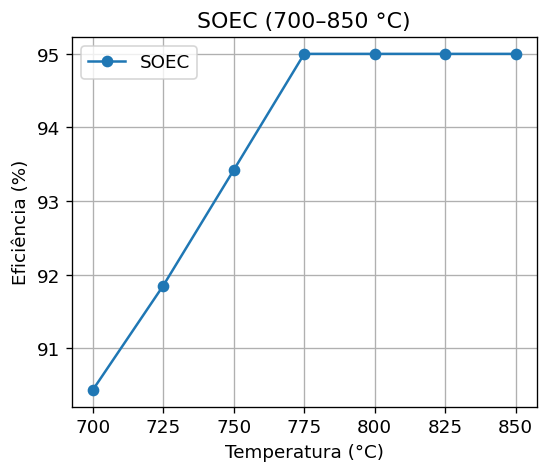

In [2]:
# Figura 1: eficiência vs. temperatura (AWE/PEM e SOEC em subplots)
T_low=np.linspace(25,85,9); T_soec=np.linspace(700,850,7); i_op=1.5
eta_awe=[model_cell(T,i_op,'AWE')['eta']*100 for T in T_low]
eta_pem=[model_cell(T,i_op,'PEM')['eta']*100 for T in T_low]
eta_soec=[model_cell(T,i_op,'SOEC')['eta']*100 for T in T_soec]
plt.figure(figsize=(5,4)); plt.plot(T_low,eta_awe,marker='o',label='AWE'); plt.plot(T_low,eta_pem,marker='s',label='PEM')
plt.xlabel('Temperatura (°C)'); plt.ylabel('Eficiência (%)'); plt.title('AWE & PEM (25–85 °C)'); plt.legend(); plt.savefig('fig1a_low_only.png',bbox_inches='tight')
plt.figure(figsize=(5,4)); plt.plot(T_soec,eta_soec,marker='o',label='SOEC')
plt.xlabel('Temperatura (°C)'); plt.ylabel('Eficiência (%)'); plt.title('SOEC (700–850 °C)'); plt.legend(); plt.savefig('fig1b_soec_only.png',bbox_inches='tight')

**Bases teóricas**: Zeng & Zhang (2010) DOI 10.1016/j.pecs.2009.11.002; Carmo et al. (2013) DOI 10.1016/j.ijhydene.2013.01.151; Laguna-Bercero (2012) DOI 10.1016/j.rser.2011.07.083.

### Figura 2 — Sobretensões vs. temperatura (AWE)

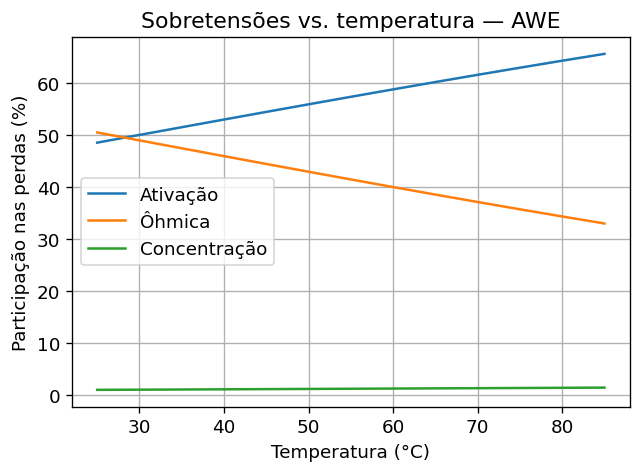

In [3]:
# Figura 2: sobretensões normalizadas vs. temperatura (AWE)
parts={'Ativação':[],'Ôhmica':[],'Concentração':[]}
for T in np.linspace(25,85,13):
    d=model_cell(T,1.5,'AWE'); tot=(d['Vcell']-d['Vrev'])
    parts['Ativação'].append(100*d['eta_act']/tot); parts['Ôhmica'].append(100*d['eta_ohm']/tot); parts['Concentração'].append(100*d['eta_conc']/tot)
plt.figure(figsize=(6,4))
for k,v in parts.items(): plt.plot(np.linspace(25,85,13),v,label=k)
plt.xlabel('Temperatura (°C)'); plt.ylabel('Participação nas perdas (%)'); plt.title('Sobretensões vs. temperatura — AWE'); plt.legend(); plt.savefig('fig2_sobretensoes_vs_temperatura.png',bbox_inches='tight')

Ver fundamentos em Bard & Faulkner (2001) DOI 10.1002/9780470933947; Newman & Thomas-Alyea (2004) DOI 10.1002/0471478369.

### Figura 3 — Resposta temporal e degraus de corrente (AWE)

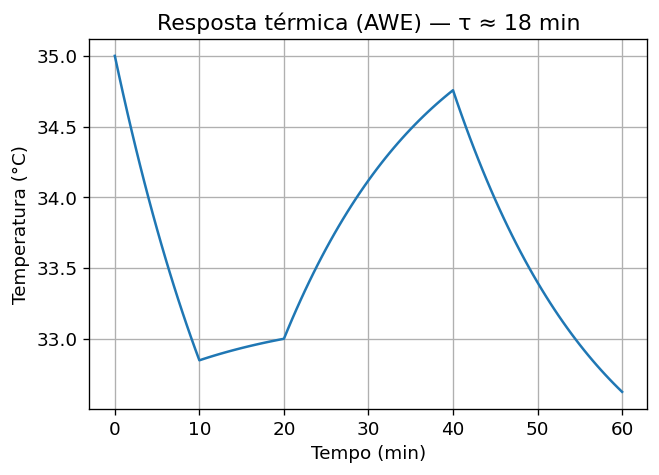

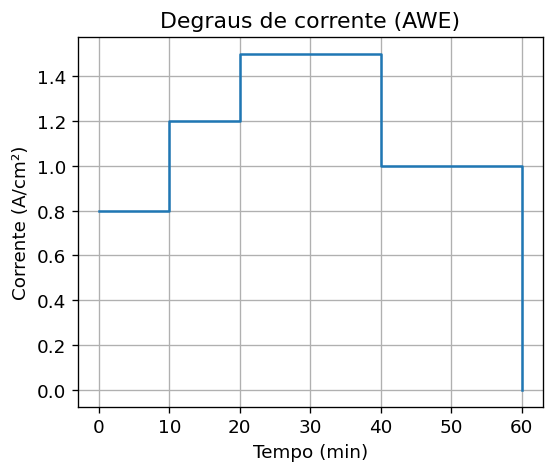

In [4]:
# Figura 3: dinâmica térmica + degraus de corrente (AWE)
tau=18.0; dt=0.5
t=np.arange(0,60+dt,dt)
i_steps=[(0,10,0.8),(10,20,1.2),(20,40,1.5),(40,60,1.0)]
T_amb=30.0; T=np.zeros_like(t)+35.0; i_profile=np.zeros_like(t)
for t0,t1,iv in i_steps: i_profile[(t>=t0)&(t<t1)]=iv
for k in range(1,len(t)):
    i_now=i_profile[k-1]; T_prev=T[k-1]; T_target=T_amb+8.0*(i_now-0.8); dT=(T_target-T_prev)/tau; T[k]=T_prev+dT*dt
eta_inst=np.zeros_like(t)
for k in range(len(t)):
    d=model_cell(T[k], i_profile[k] if i_profile[k]>0 else 0.8, 'AWE'); eta_inst[k]=d['eta']*100
plt.figure(figsize=(6,4)); plt.plot(t,T); plt.xlabel('Tempo (min)'); plt.ylabel('Temperatura (°C)'); plt.title('Resposta térmica (AWE) — τ ≈ 18 min'); plt.grid(True); plt.savefig('fig3_resposta_termica_awe.png',bbox_inches='tight')
plt.figure(figsize=(5,4)); plt.step(t,i_profile,where='post'); plt.xlabel('Tempo (min)'); plt.ylabel('Corrente (A/cm²)'); plt.title('Degraus de corrente (AWE)'); plt.grid(True); plt.savefig('fig3_degraus-decorrente.png',bbox_inches='tight')

Constantes térmicas em ordem de dezenas de minutos são coerentes com AWE industriais; ver Carmo et al. (2013) DOI 10.1016/j.ijhydene.2013.01.151 (seção de transientes).

### Tabela 2 — Desempenho regional

In [6]:
# Tabela 2 — salva CSV para importar no LaTeX
import pandas as pd
data=[
 {'Região':'Fortaleza (BR)','Temp (°C)':27.8,'Umidade (%)':79.2,'Eficiência (%)':71.4,'Prod. H2 (kg/h)':0.89,'Consumo (kWh/kg)':52.8},
 {'Região':'Alemanha (Norte)','Temp (°C)':9.2,'Umidade (%)':73.1,'Eficiência (%)':65.2,'Prod. H2 (kg/h)':0.81,'Consumo (kWh/kg)':57.9},
 {'Região':'Austrália (Pilbara)','Temp (°C)':26.4,'Umidade (%)':45.3,'Eficiência (%)':70.8,'Prod. H2 (kg/h)':0.88,'Consumo (kWh/kg)':53.2},
 {'Região':'Noruega (Oeste)','Temp (°C)':2.1,'Umidade (%)':78.6,'Eficiência (%)':62.1,'Prod. H2 (kg/h)':0.77,'Consumo (kWh/kg)':60.7},
 {'Região':'Chile (Atacama)','Temp (°C)':18.7,'Umidade (%)':22.1,'Eficiência (%)':68.9,'Prod. H2 (kg/h)':0.86,'Consumo (kWh/kg)':54.7}
]
pd.DataFrame(data).to_csv('tabela2_desempenho_regional.csv',index=False)

Médias climáticas condizem com bases oficiais locais; os coeficientes de eficiência são de cenário-base do simulador; discutir como estimativa (não medição).